In [2]:
import igraph as ig
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import zip_longest
from itertools import islice
from tqdm import tqdm

# Degree Analysis

Compare degree distributions & other degree-based stats over updates

## Degree distributions

Comparisons of degree distributions across updates

In [3]:
def degree_dist_plot(degrees):
    plt.plot(degrees, color="#fdc799", alpha=0.8) #, np.arange(0,len(degrees),1))
    plt.loglog()

In [31]:
#Quarterly update strings
test = ["20150401", "20150701"]
updates = [
        "20150401", "20150701", "20151001", "20160101", "20160401", "20160701",
        "20161001", "20170101", "20170401", "20170701", "20171001", "20180101",
        "20180401", "20180701", "20181001", "20190101", "20190401", "20190701",
        "20191001", "20200101", "20200401", "20200701", "20201001", "20210101"
    ]

#Load all degrees associated with quarterly updates
all_degrees = []
for update in updates:
    degrees = pickle.load(file=open("Data/Degrees/degrees_" + update + ".p", "rb"))
    degrees.sort(reverse=True)
    all_degrees.append(degrees)

#Calculate & plot average of all degrees (avg over each column)
avg = [np.ma.average(np.ma.masked_values(temp_list,None)) for temp_list in zip_longest(*all_degrees)]

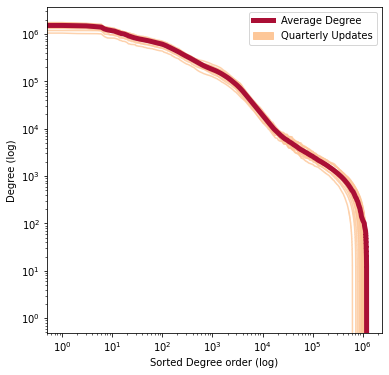

In [42]:
#Plot degree distribution comparisons
plt.figure(figsize=(6,6))

#Quarterly update
for degrees in all_degrees:
    degree_dist_plot(degrees)

#Average over all degrees
#avg.sort(reverse=True)
plt.plot(avg, color="#aa0f35", linewidth=5.0, label="Average Degree")

plt.xlabel("Sorted Degree order (log)")
plt.ylabel("Degree (log)")

#Add legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color="#fdc799", label="Quarterly Updates"))
plt.legend(handles=handles)


## Attachment 

Calculate attachment over quarterly updates (see Rednar 2004 as a guide)

### Preferential Attachment calculations

Set up & perform preferential attachment calculations

In [4]:
#Test on two linked updates
test = ["20150401", "20150701"]

updates = [
        "20150401", "20150701", "20151001", "20160101", "20160401", "20160701",
        "20161001", "20170101", "20170401", "20170701", "20171001", "20180101",
        "20180401", "20180701", "20181001", "20190101", "20190401", "20190701",
        "20191001", "20200101", "20200401", "20200701", "20201001", "20210101"
    ]

# TODO Define dictionary - will be [id: [list of degrees of len(updates)]]
full_id_degrees = {}
size = len(updates) #can be test/updates

for i in tqdm(range(len(updates))):
    #Load id_degree dictionary
    id_degrees = pickle.load(file=open("Data/Degrees/id_degrees_" + updates[i] + ".p", "rb"))

    # TODO Add / update to full dictionary. 

    for key, value in id_degrees.items():
        #If a id is in the dictionary, update the appropriate degree value
        if key in full_id_degrees:
            full_id_degrees[key][i] = sum(full_id_degrees[key]) + value
        # If a id is not in the dictionary, add it with a list of len(updates) 0s and update the appropriate degree value
        else:
            full_id_degrees[key] = [0]*size
            full_id_degrees[key][i] = value

print(list(islice(full_id_degrees.items(), 10)))

    

100%|██████████| 24/24 [00:42<00:00,  1.75s/it]

[('SCHEMBL16009082', [918, 1842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3696, 0, 0, 0, 0, 0, 0]), ('SCHEMBL682789', [2412, 0, 0, 0, 0, 0, 0, 0, 0, 3629, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL15794039', [375, 0, 0, 1281, 0, 2197, 0, 0, 4418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL15109686', [356, 0, 0, 1073, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL5631980', [2423, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL75205', [5032, 7002, 18556, 31249, 66247, 132864, 261174, 531156, 1057125, 2121935, 4235793, 8474758, 16949307, 33895251, 67788271, 135579863, 271159468, 542322070, 1084640502, 2169279450, 4338558379, 8677128046, 17354250039, 34708499168]), ('SCHEMBL13468774', [833, 1450, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL16585443', [1132, 0, 0, 0, 0, 0, 0, 0, 0, 2391, 0, 0, 0, 4759, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('SCHEMBL13782620', [648, 0, 0, 0, 0, 0,

In [5]:
#Replace all zero values with the last non-zero value
for key, value in tqdm(full_id_degrees.items()):
    arr = np.array(value)
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)
    full_id_degrees[key] = arr[prev]

100%|██████████| 8951018/8951018 [01:13<00:00, 122337.46it/s]


In [11]:
#Calculate preferential attachment
pref_attach_dict = {}

for key, value in tqdm(full_id_degrees.items()):
    c = 0
    attachments = []
    while c < len(value) - 1:
        attachments.append(value[c+1] - value[c])
        c += 1
    pref_attach_dict[key] = np.mean(attachments)

100%|██████████| 8951018/8951018 [04:05<00:00, 36450.04it/s]


### Preferential Attachment graphing

Initially inspired by Redner (2004) - citations on x axis, attachment rate on y axis

In [15]:
#Create two list of initial degrees
initial_degrees = []
for key, value in full_id_degrees.items():
    initial_degrees.append(value[0])

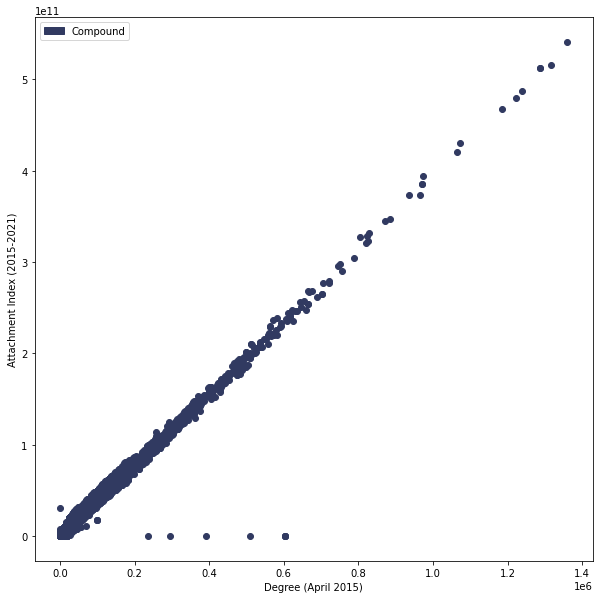

In [19]:
plt.figure(figsize=(10,10))

plt.scatter(x=initial_degrees, y=pref_attach_dict.values(), color="#313a61")

plt.xlabel("Degree (April 2015)")
plt.ylabel("Attachment Index (2015-2021)")

#Add legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color="#313a61", label="Compound"))
plt.legend(handles=handles, loc="upper left")

# Connectivity analysis

_Question:_ Does connectivity increase over time within SureChemBL? 

_Hypothesis:_ patents become more connective over time, thereby using more of the same chemical space over time

## Bipartite stats

Use basic statistics (number of nodes & edges of both cpds & patents) from bipartite network analysis to test percent connectivity

In [2]:
df = pd.read_csv("Data/Graphs/bipartite_sizes.csv")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Graphs/bipartite_sizes.csv'

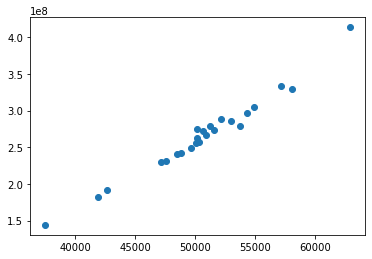

In [13]:
#Does patent nodes scale with patent edges?
plt.scatter(x=df["patent_nodes"], y=df["patent_edges"])

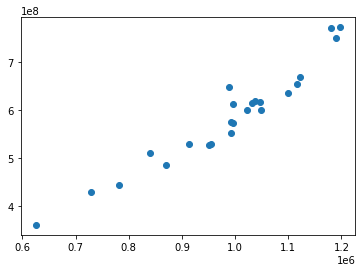

In [14]:
#How about compounds?
plt.scatter(x=df["cpd_nodes"], y=df["cpd_edges"])

In [6]:
#Test graph analysis
G = pickle.load(file=open("Data/Graphs/G_20210101.p", "rb"))
print(ig.summary(G))

IGRAPH UN-T 1162328 4555905 -- 
+ attr: date (v), name (v), type (v)
None
